In [1]:
import pandas as pd
import plotnine as p9
import numpy as np
import matplotlib as mpl

# Force figure and saved figure backgrounds to white
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'


In [2]:
# read data

results_df = pd.read_csv("Simulations/results/simulation_results_CAR_model.csv")


In [3]:
# save summary stat across iterations


# model_order = ["true_net", "MWG", "MWG_rep", "obs_net"]
# results_df["model"] = pd.Categorical(results_df["model"], categories=model_order, ordered=True)


# Define model order and rename categories
model_rename = {
    "true_net": "True",
    "obs_net": "Obs",
    "MWG": "MWG",
    "MWG_rep": "MWG_rep"
}

results_df["model"] = results_df["model"].replace(model_rename)
results_df["model"] = pd.Categorical(results_df["model"], categories=model_rename.values(), ordered=True)



summary_df = (
    results_df
    .groupby(["gamma_noise", "model", "estimand"])
    .agg(
        mean_RMSE_rel=("RMSE_rel", "mean"),
        mean_RMSE_rel_std=("RMSE_rel", "std"),
        rmse_rel_q5=("RMSE_rel", lambda x: np.percentile(x, 5)),
        rmse_rel_q95=("RMSE_rel", lambda x: np.percentile(x, 95)),

        mean_MAPE = ("MAPE", "mean"),
        median_MAPE = ("MAPE", "median"),
        mean_MAPE_std = ("MAPE", "std"),
        mape_q5 = ("MAPE", lambda x: np.percentile(x, 5)),
        mape_q95 = ("MAPE", lambda x: np.percentile(x, 95)),
       
       
        cover = ("covering", "mean"),
        ind_cover = ("mean_ind_cover", "mean"),

        w_dist = ("w_dist", "mean"),

        mean = ("mean", "mean"),
        median = ("median", "median"),
        std = ("std", "mean"),
        true = ("true", "mean"),
        true_std = ("true", "std"),

        mean_975 = ("q975", "mean"),
        mean_025 = ("q025", "mean"),

        bias = ("bias", "mean"),
        bias_std = ("bias", "std"),
        )
    .reset_index()
)

summary_df["lower_rmse"] = summary_df["mean_RMSE_rel"] - summary_df["mean_RMSE_rel_std"]
summary_df["upper_rmse"] = summary_df["mean_RMSE_rel"] + summary_df["mean_RMSE_rel_std"]

summary_df["lower_mape"] = summary_df["mean_MAPE"] - summary_df["mean_MAPE_std"]
summary_df["upper_mape"] = summary_df["mean_MAPE"] + summary_df["mean_MAPE_std"]


summary_df = summary_df[summary_df["estimand"] != "estimand"]


C:\Users\bar21\AppData\Local\Temp\ipykernel_9168\1172839843.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [11]:
# results_df[results_df.w_dist == results_df.w_dist.min()]
results_df.loc[results_df[results_df["model"] == "MWG"]["w_dist"].idxmin(),]

idx                 21_4_2
model                  MWG
estimand           dynamic
gamma_noise            3.0
mean               4.12958
median             3.70836
true               4.07703
bias               0.05256
std                0.11949
RMSE               0.13054
RMSE_rel           0.03202
MAE                0.61237
MAPE               0.18503
q025              3.912493
q975              4.361957
covering               1.0
mean_ind_cover        0.97
w_dist             1.35246
iteration             21_4
Name: 4172, dtype: object

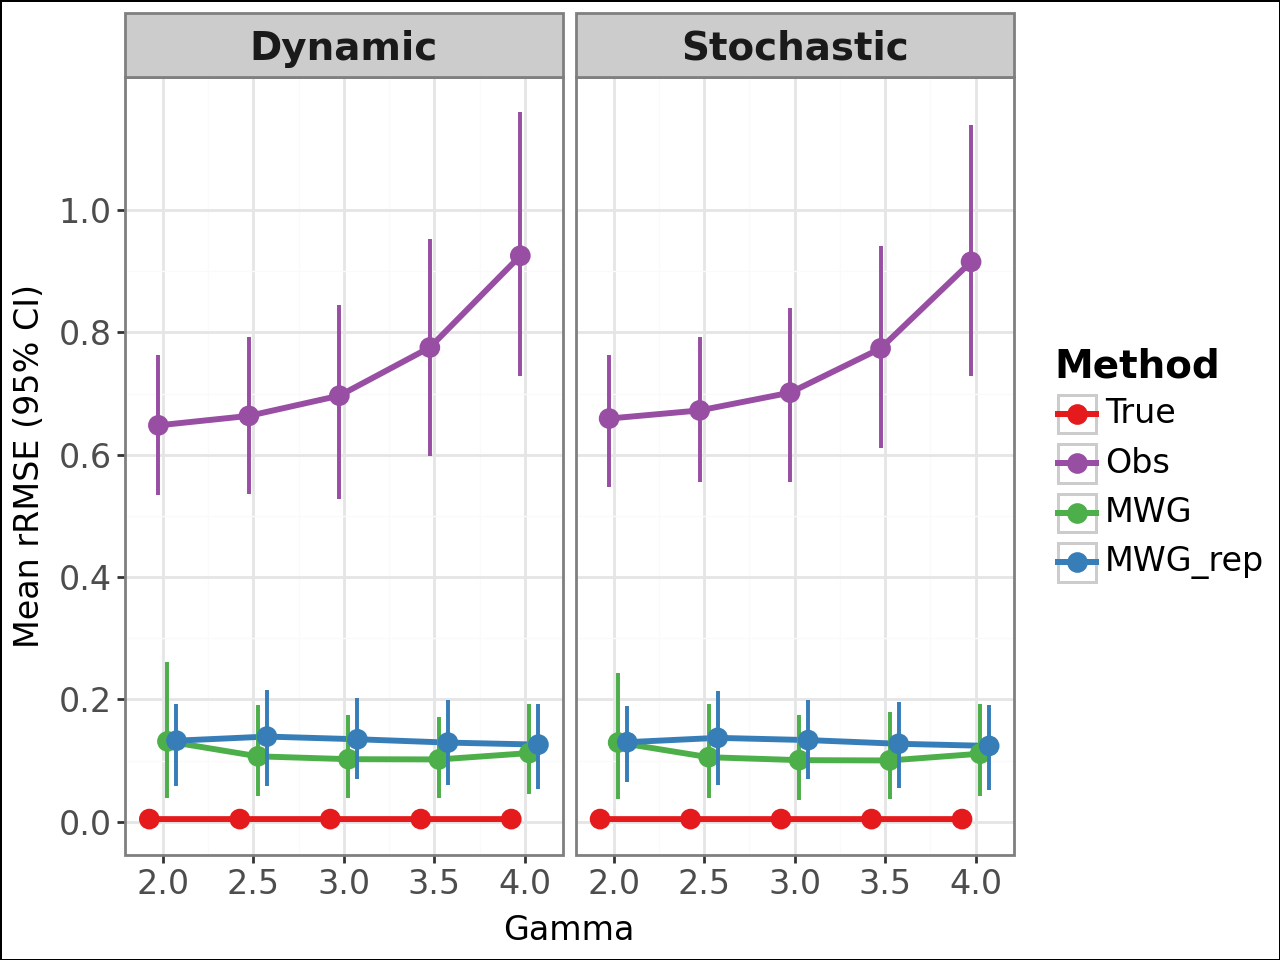

c:\Users\bar21\.conda\envs\STAT\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\bar21\.conda\envs\STAT\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: Simulations/results/figs/plot_RMSE_rel.png


In [4]:

# Rename facet titles
facet_labels = {"dynamic": "Dynamic", "stoch": "Stochastic"}
summary_df["estimand"] = summary_df["estimand"].replace(facet_labels)


custom_palette = {
    "True": "#E41A1C",   # Red
    "MWG": "#4DAF4A",        # Green
    "MWG_rep": "#377EB8",    # Blue
    "Obs": "#984EA3"     # Purple
}

plot = (
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                 y="mean_RMSE_rel", 
                                 group="model", 
                                 color="model"))
    + p9.geom_line(position=p9.position_dodge(width=0.2), size=1.2)  
    + p9.geom_pointrange(
        p9.aes(ymin="rmse_rel_q5", ymax="rmse_rel_q95"),
        position=p9.position_dodge(width=0.2),
        size=0.8  
    )
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")

    + p9.labs(y="Mean rRMSE (95% CI)", x="Gamma", color="Method")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    + p9.scale_y_continuous(breaks=np.arange(0, 1.2, 0.2))

    + p9.scale_color_manual(values=custom_palette)
    + p9.theme(
        legend_title=p9.element_text(size=14, weight='bold'),
        legend_text=p9.element_text(size=12),
        axis_title_x=p9.element_text(size=12,),
        axis_title_y=p9.element_text(size=12,),
        axis_text_x=p9.element_text(size=12),
        axis_text_y=p9.element_text(size=12),
        strip_text=p9.element_text(size=14, weight='bold'),  
    )
)

plot.show()

plot.save("Simulations/results/figs/plot_RMSE_rel.png", dpi=300)

The plot shows the mean (95% percentiles) of relative RMSE for each estimand (dynamic and stochastic) across 'gamma' values. As we move right in the x-axis, the level of noise increases and proxy networks becomes weaker. 

Let $\hat{\tau}_m$ be the estimates in posterior sample $m=1,\ldots,M$. In our case $M=10^4$. The relative MSE is defined as 

$$
rMSE = M^{-1} \sum_m \Big(\frac{\hat{\tau}_m -\tau}{\tau}\Big)^2
$$

and relative RMSE is $rRMSE = \sqrt{rMSE}$.
\
rRMSE therefore accounts for precision of estimates and uncertainty in the posterior estimates (over outcome model parameters and true latent network $A^\ast$).
\
Each point is the mean (95% CI) across $300$ iterations (so total $300 \times 5$ iterations including different $\gamma$ values) and for $N=500$ units.